In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
import copy
import math
import seaborn as sns

sns.set_style()

## Neural Network

In [ ]:
class NNet(nn.Module):
  def __init__(self,ipSize=2):
    super().__init__()
    dim0,dim1=8,1
    self.fc1=nn.Sequential(nn.Linear(ipSize,dim0),
                           nn.ReLU(),
                           nn.Linear(dim0,dim1),
                           nn.Sigmoid())
  def forward(self,x):
    return self.fc1(x)
  def display(self):
    for name, param in self.fc1.named_parameters():
      if 'weight' in name:
          print(name, param.shape,param.dtype)

# Loss Function (MSE)
def loss1(YP,Y):
  return torch.mean((YP-Y)**2,axis=0)
# Loss Function (Logistic Regression)
def loss2(YP,Y):
  temp=-(1-Y)*torch.log(1-YP)-Y*torch.log(YP)
  return torch.mean(temp,axis=0)

# Train.
def train(model,X,Y,optim,lfunc,mxEpoch,verbose=False):
  model.train()
  for e in range(mxEpoch):
    YP=model(X)
    optim.zero_grad()
    loss=lfunc(YP,Y)
    loss.backward()
    optim.step()
    if verbose==True and e%5==0:
      print(f'Epoch: {e}; Loss: {loss.item()}')
    return loss.item()

## Preparing Training Examples.

In [ ]:
m=1000 # No of training examples.
tr_noise_std=0.2
dim=2
X=np.random.randint(0,2,size=(m,dim))
Y=X[:,0]^X[:,1]
X=X+np.random.normal(0,tr_noise_std,size=(m,dim))

X=torch.tensor(X,dtype=torch.float32)
Y=torch.tensor(Y,dtype=torch.float32).unsqueeze(1)

## DBG1

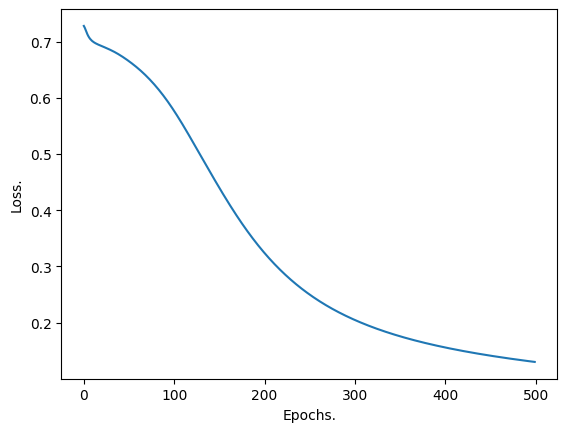

In [ ]:
dbg1=True
if dbg1==True:
  model=NNet(ipSize=2)
  optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
  loss_arr=[]
  MX_EPOCHS=500
  for _ in range(MX_EPOCHS):
    loss_arr.append(train(model,X,Y,optimizer,loss2,1,verbose=False))
  plt.plot(loss_arr)
  plt.xlabel('Epochs.')
  plt.ylabel('Loss.')
  plt.show()
  print()

## Kantz's Class
> Pass the **parent model** with **name** to this class, the code will create 5 child model with slight variations.

In [ ]:
!rm -rf dat/
!mkdir dat

In [ ]:
class NNKantz():
  def __init__(self,fname,parentModel,child=5,std=0.0001,mxEpochs=200):
    with torch.no_grad():
      self.lim=mxEpochs*0.25
      self.std=std
      self.pModel=parentModel
      self.lyap_k=[]
      self.child_model=[f'{fname}']+[f'{fname}_c{i}' for i in range(child)]
      for id_o,cname in enumerate(self.child_model):
        for id,layer in enumerate(self.pModel.parameters()):
          lc=copy.deepcopy(layer)
          if id_o!=0:
            lc.data=lc.data+torch.normal(0,self.std,size=lc.shape)
          torch.save(lc,f'dat/{cname}_layer{id}')
  # Which Child Model you want to load ?
  def load_model(self,model,fname):
    with torch.no_grad():
      for id,layer in enumerate(model.parameters()):
        layer=torch.load(f'dat/{fname}_layer{id}')
  # Which Child Model you want to save ?
  def save_model(self,model,fname):
    with torch.no_grad():
      for id,layer in enumerate(model.parameters()):
        torch.save(layer,f'dat/{fname}_layer{id}')
  # Kantz distance
  def kantz(self):
    with torch.no_grad():
      if self.lim==0:
        return
      self.lim-=1
      sz=len(self.child_model)
      dummy=NNet(ipSize=2)
      wts=[]
      self.load_model(self.pModel,self.child_model[0])
      for layer_p in self.pModel.parameters():
        wts.append(layer_p.data)
      sum_sum=0
      for cid in range(1,sz):
        self.load_model(dummy,self.child_model[cid])
        sum=0
        for id,layer in enumerate(dummy.parameters()):
          sum+=torch.sum((wts[id]-layer.data)**2).item()
        dist=math.sqrt(sum)
      if sz>1:
        sum_sum+=dist/(sz-1)
      self.lyap_k.append(math.log(sum_sum))
  # Get lyap_k distance
  def get_lyap_k(self):
      return sum(self.lyap_k)/len(self.lyap_k)

## DBG2

In [ ]:
dbg2=True
if dbg2==True:
  model=NNet(ipSize=2)
  m1=NNKantz('alpha',model)

## Main Code.

#### Utils Cell.

In [ ]:
def getUniqueName(dname,name_len):
  while True:
    s=''
    for _ in range(name_len):
      s=s+chr(ord('a')+np.random.randint(0,26))
    if s not in dname:
     dname[s]=True
     break
  return s

In [ ]:
noOfModels=50 # These many random points
mArr=[] # Model array.
nArr,dname,name_len=[],{},10 # Name array.
mx_epochs=100
for _ in range(noOfModels):
  model=NNet(ipSize=2)
  nArr.append(getUniqueName(dname,name_len))
  mArr.append(NNKantz(nArr[-1],model,child=10,mxEpochs=mx_epochs))

model=NNet(ipSize=2)
model_loss_arr=[[[] for __ in range(mx_epochs)] for _ in range(noOfModels)]
for epoch in range(mx_epochs):
  for i,m in enumerate(mArr):
    for mname in m.child_model:
      m.load_model(model,mname)
      optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
      model_loss_arr[i][epoch].append(train(model,X,Y,optimizer,loss1,1,verbose=False))
      m.save_model(model,mname)
    m.kantz()

lyap_arr=[]
for i,m in enumerate(mArr):
  lyap_arr.append(m.get_lyap_k())
model_loss_arr=np.array(model_loss_arr)

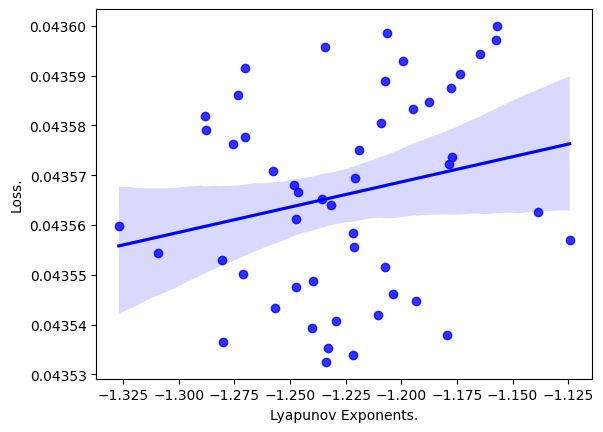

In [ ]:
# coeff=(int)(mx_epochs*0.25)
# m_arr= model_loss_arr[:,0,0]-model_loss_arr[:,coeff,0]
coeff=-1
m_arr= model_loss_arr[:,coeff,0]
sns.regplot(x = lyap_arr,y = m_arr,color='blue')
plt.xlabel('Lyapunov Exponents.')
plt.ylabel('Loss.')
plt.savefig('L1.png')
plt.show()

In [ ]:
import scipy.stats
print(scipy.stats.pearsonr(lyap_arr,m_arr))
print(sum(lyap_arr)/len(lyap_arr))
print(sum(m_arr)/len(m_arr))

PearsonRResult(statistic=0.2225573577580866, pvalue=0.12031102650915648)
-1.2253412629705354
0.043566088974475864


In [ ]:
noOfModels=50 # These many random points
mArr=[] # Model array.
nArr,dname,name_len=[],{},10 # Name array.
mx_epochs=100
for _ in range(noOfModels):
  model=NNet(ipSize=2)
  nArr.append(getUniqueName(dname,name_len))
  mArr.append(NNKantz(nArr[-1],model,child=10,mxEpochs=mx_epochs))

model=NNet(ipSize=2)
model_loss_arr2=[[[] for __ in range(mx_epochs)] for _ in range(noOfModels)]
for epoch in range(mx_epochs):
  for i,m in enumerate(mArr):
    for mname in m.child_model:
      m.load_model(model,mname)
      optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
      model_loss_arr2[i][epoch].append(train(model,X,Y,optimizer,loss2,1,verbose=False))
      m.save_model(model,mname)
    m.kantz()

lyap_arr2=[]
for i,m in enumerate(mArr):
  lyap_arr2.append(m.get_lyap_k())
model_loss_arr2=np.array(model_loss_arr2)

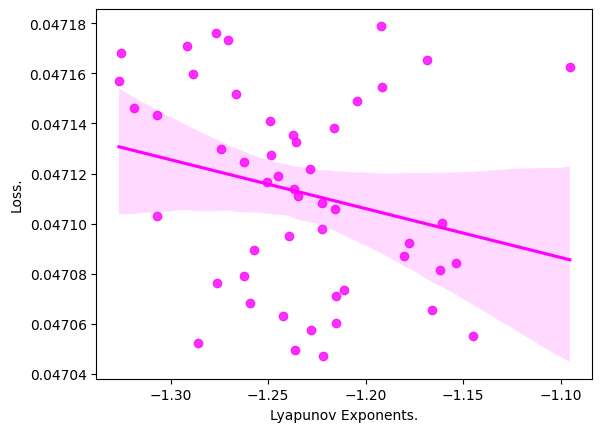

In [ ]:
coeff=65
m_arr2=model_loss_arr2[:,coeff,0]
sns.regplot(x = lyap_arr2,y = m_arr2,color='magenta')
plt.xlabel('Lyapunov Exponents.')
plt.ylabel('Loss.')
plt.savefig('L2.png')
plt.show()

In [ ]:
import scipy.stats
print(scipy.stats.pearsonr(lyap_arr2,m_arr2))
print(sum(lyap_arr2)/len(lyap_arr2))
print(sum(m_arr2)/len(m_arr2))

PearsonRResult(statistic=-0.2475040450199869, pvalue=0.08310849342497426)
-1.2340632381803152
0.04711262211203575


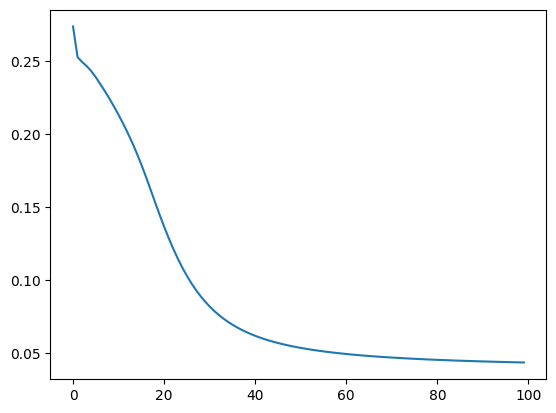

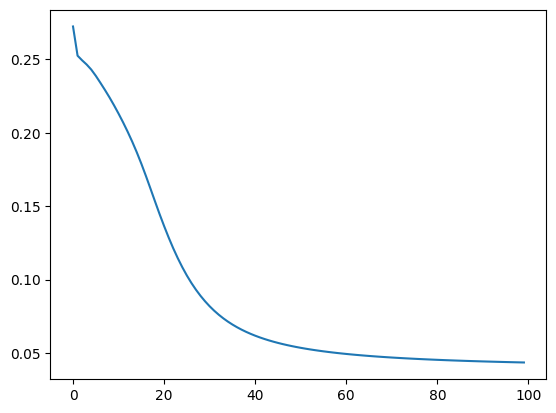

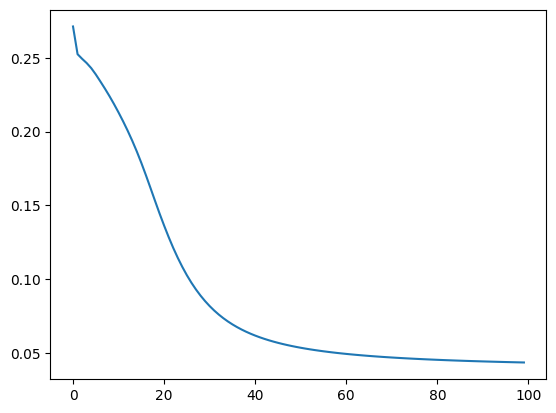

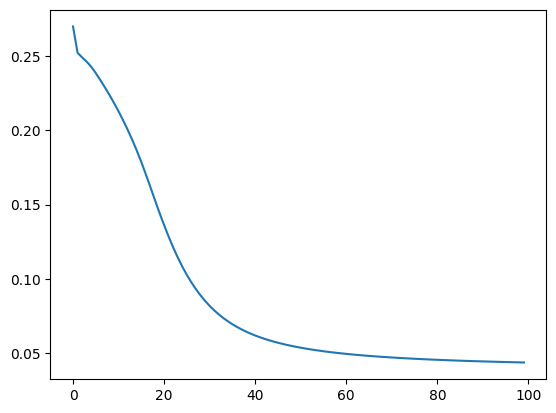

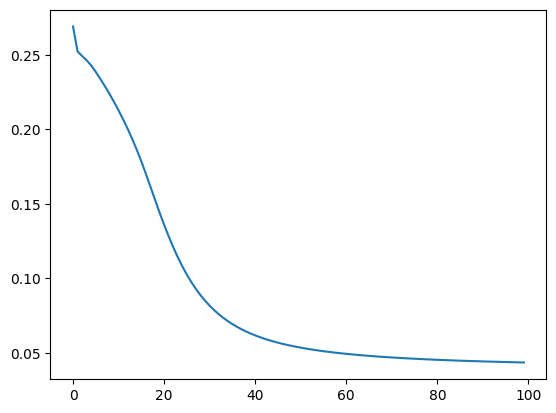

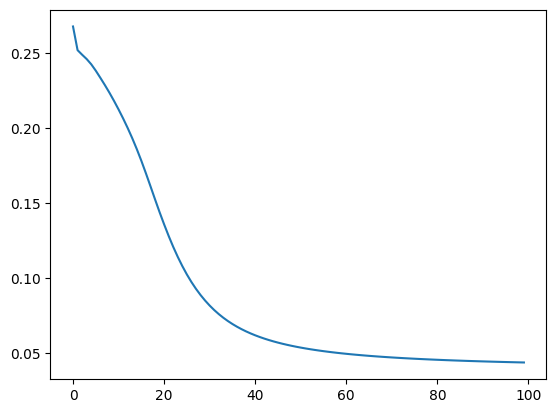

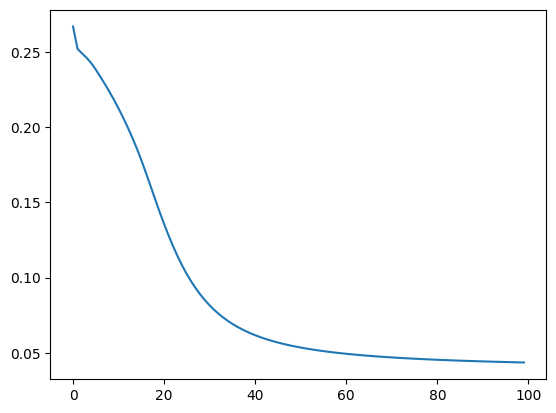

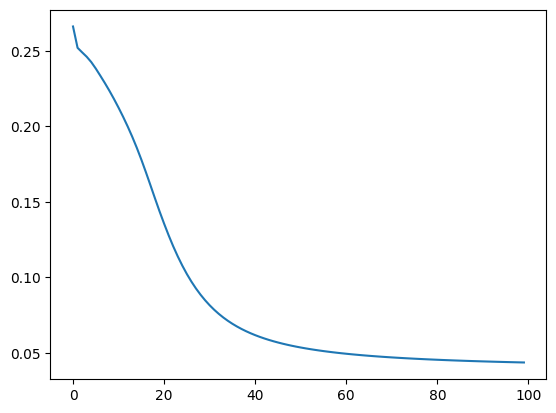

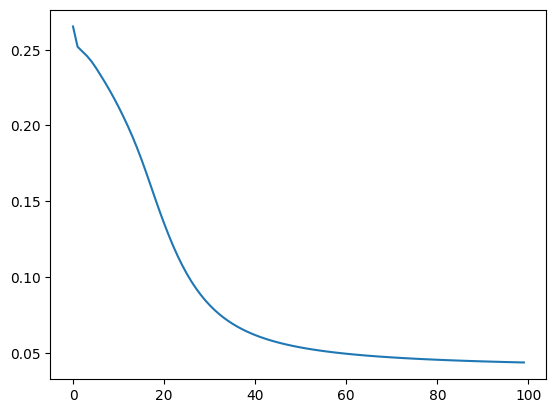

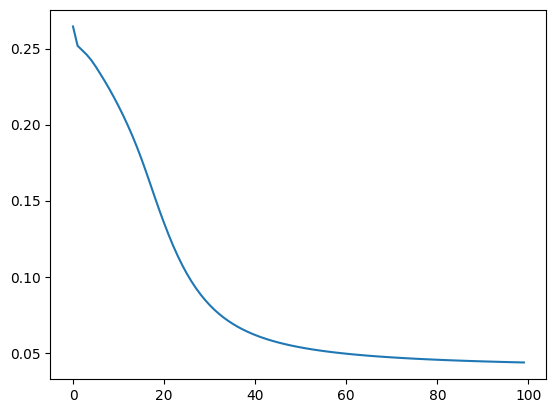

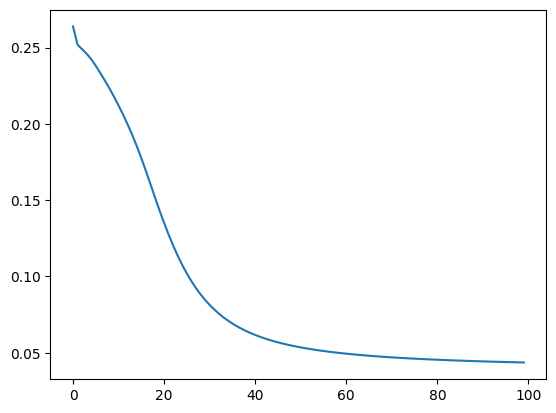

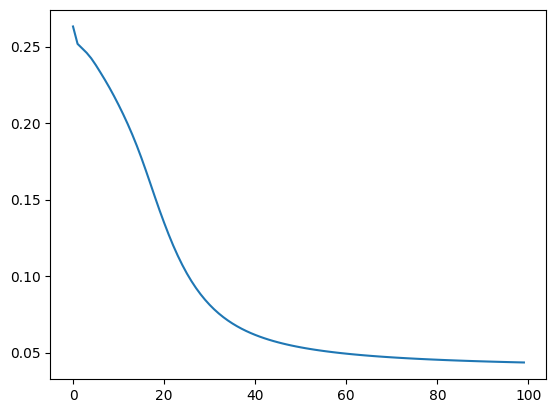

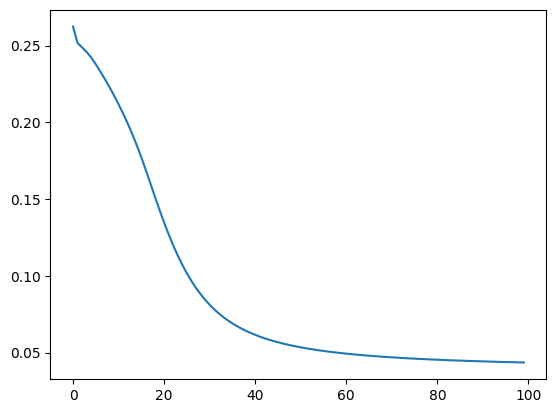

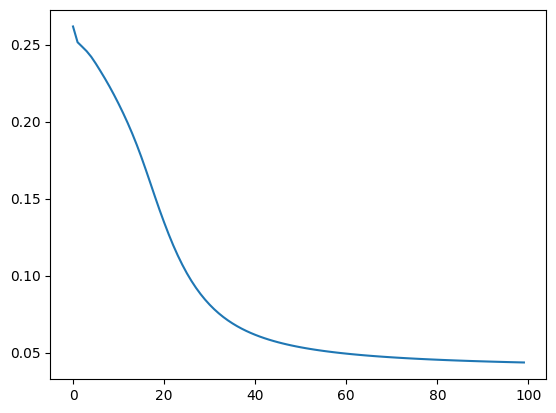

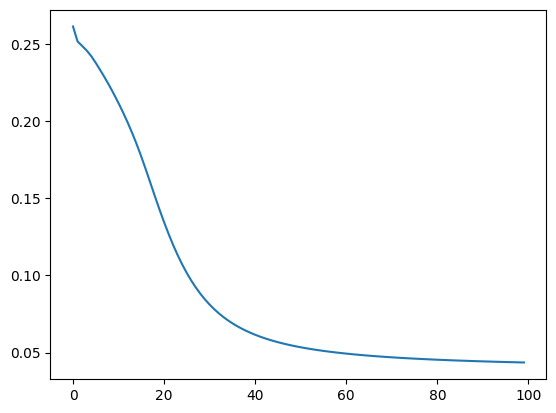

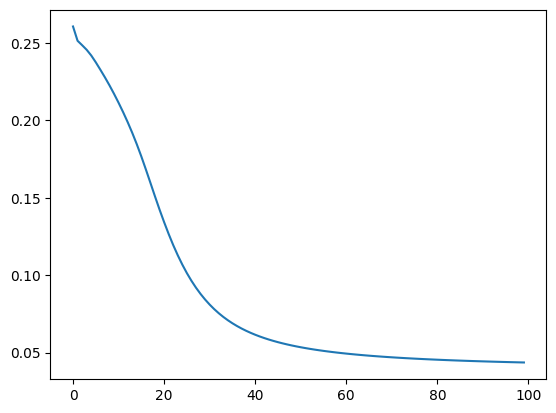

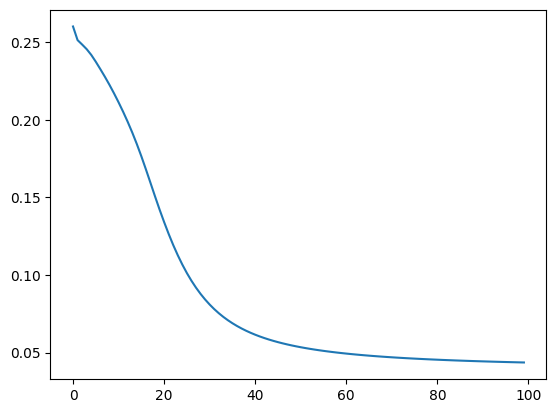

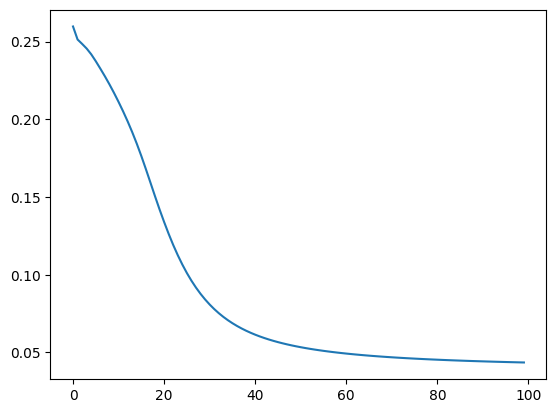

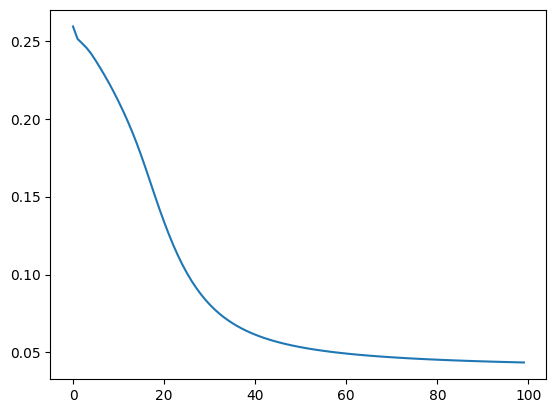

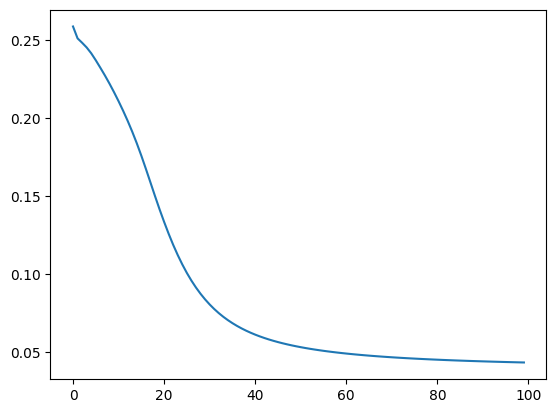

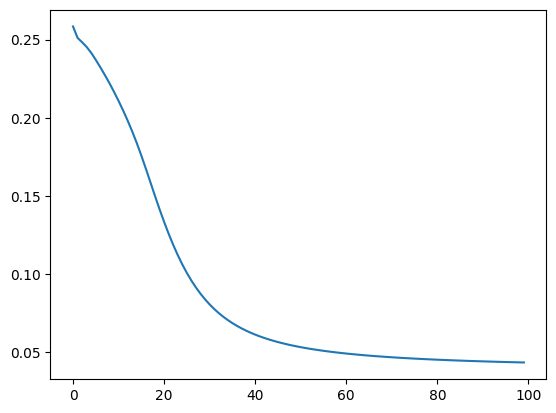

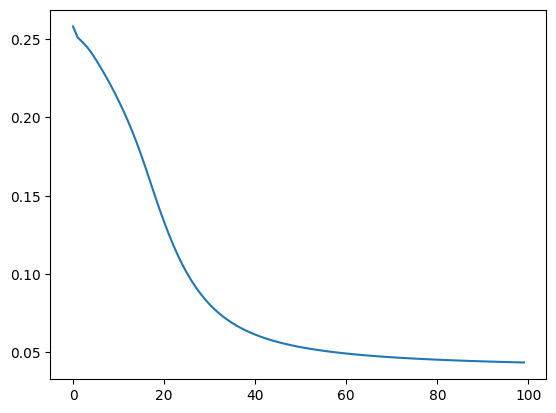

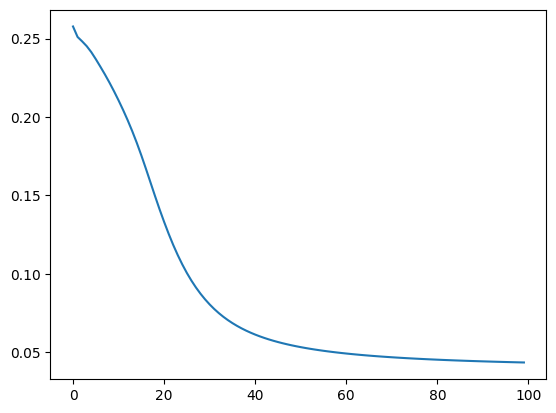

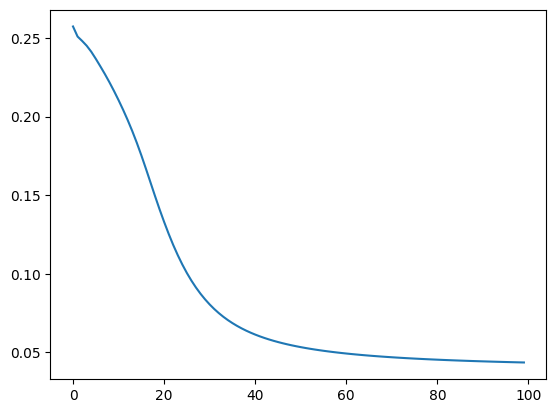

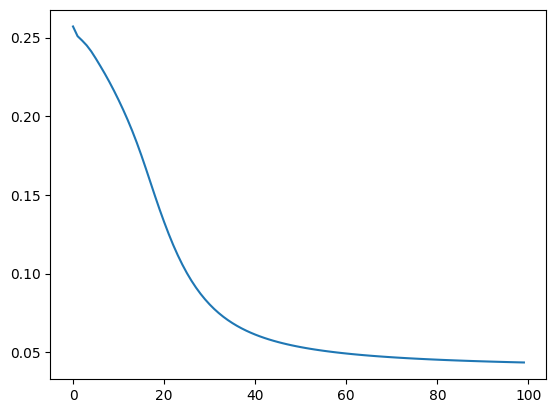

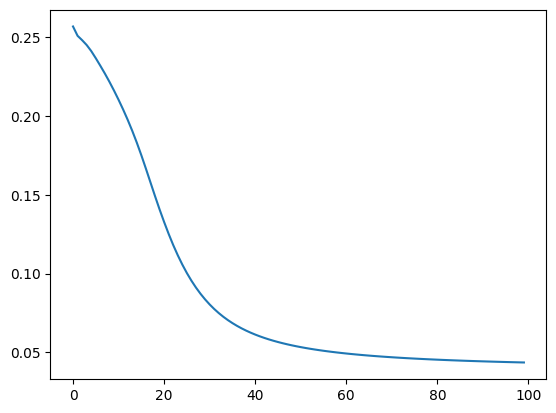

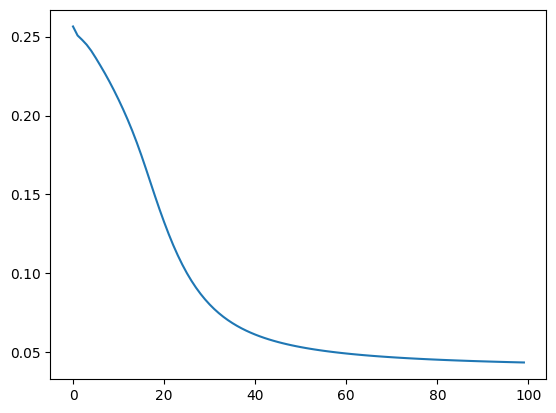

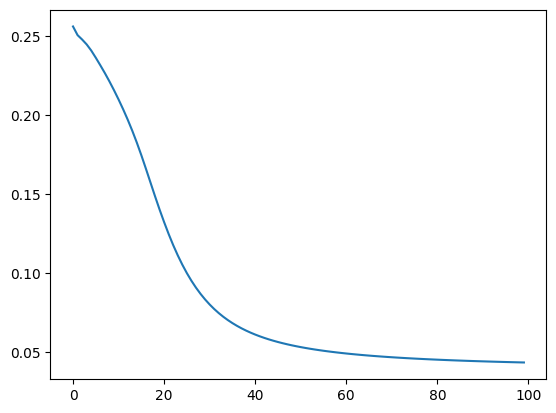

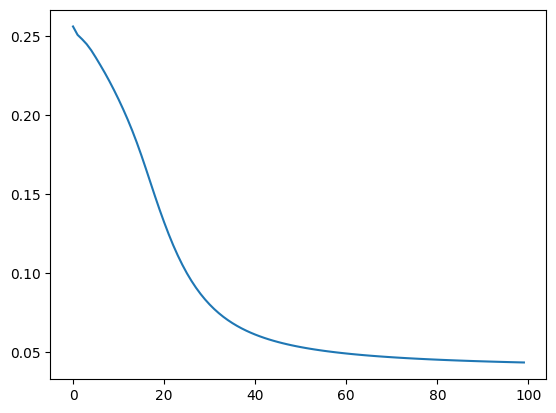

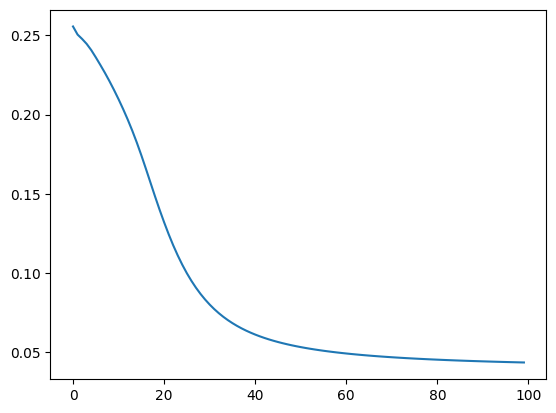

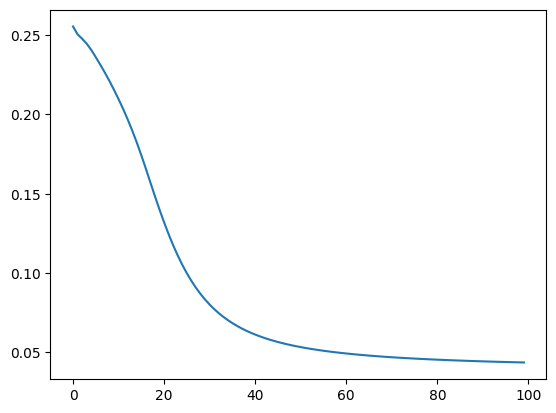

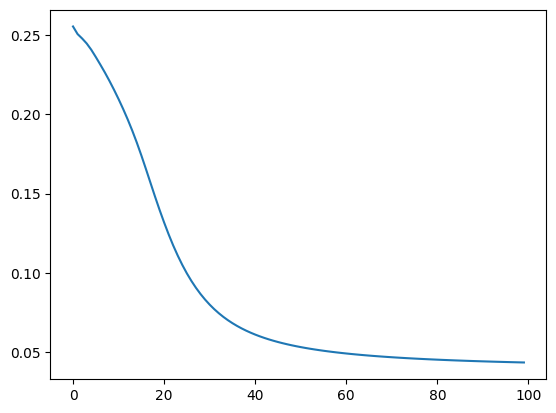

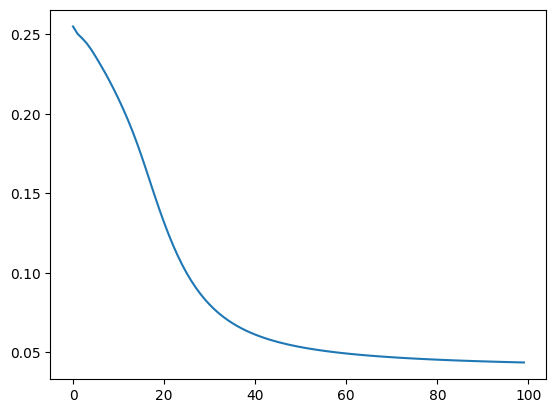

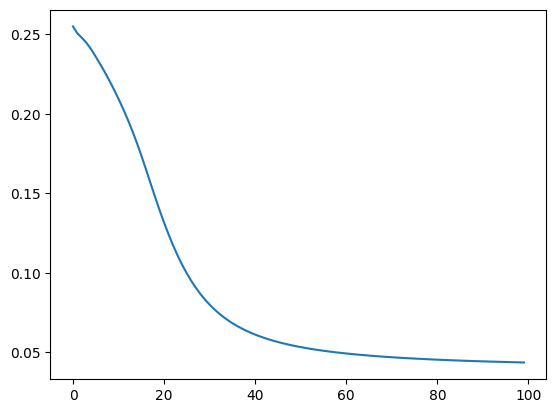

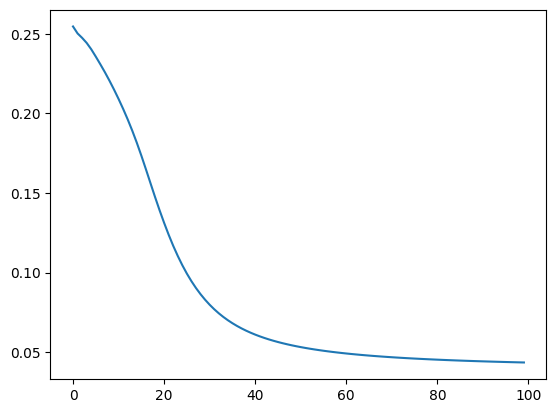

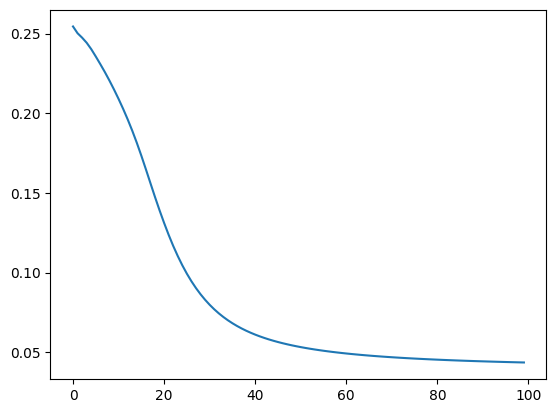

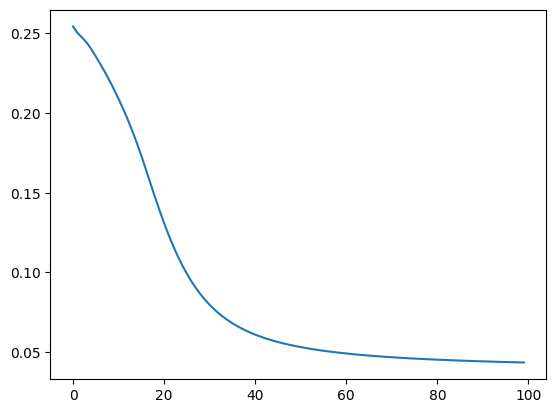

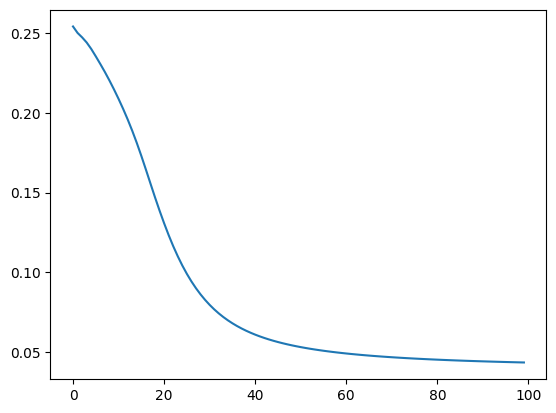

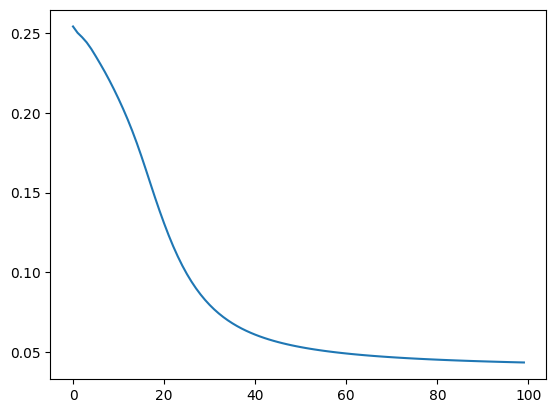

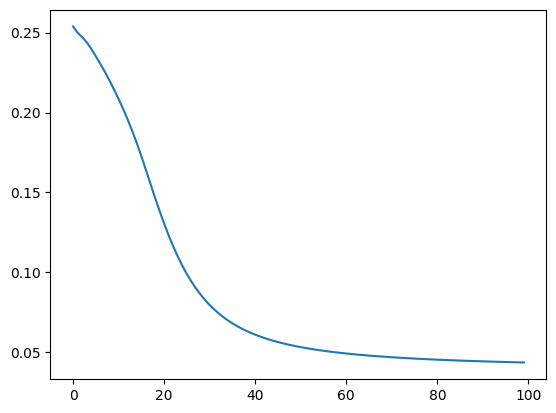

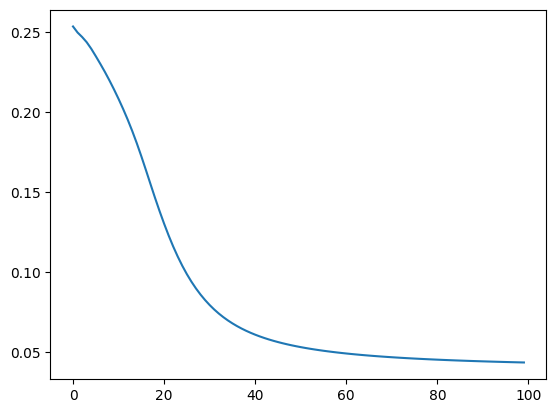

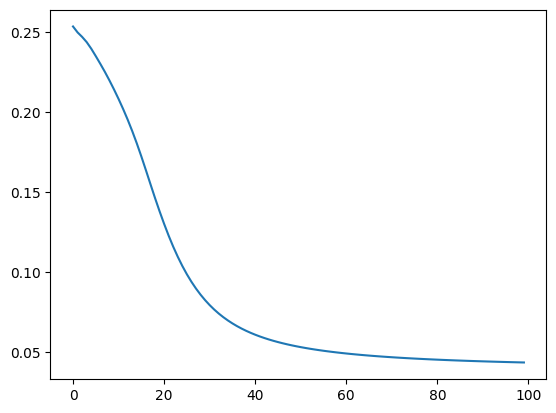

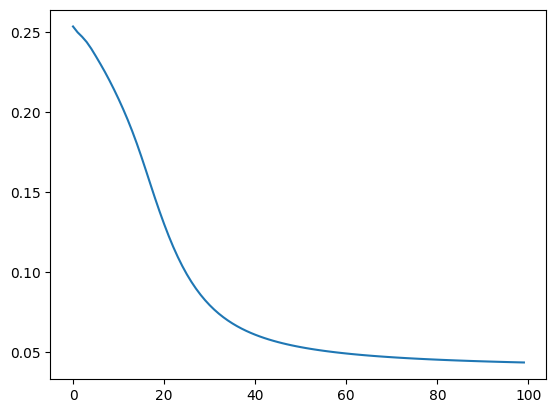

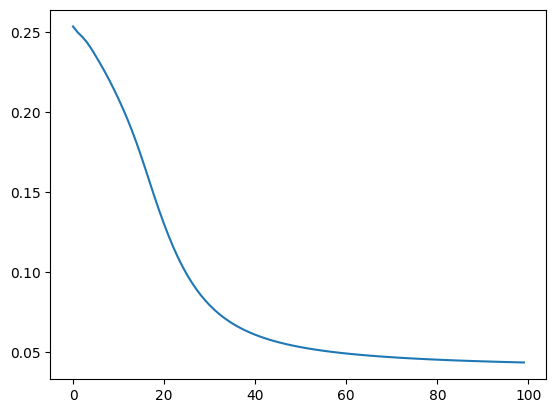

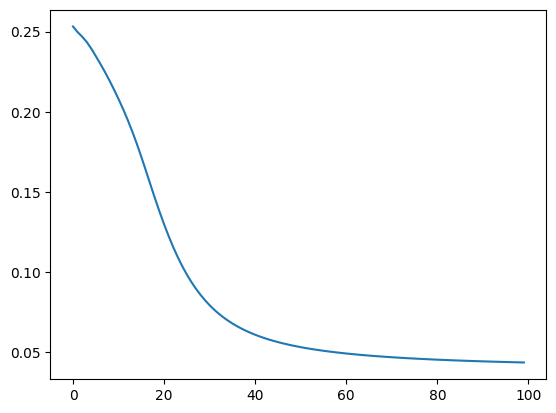

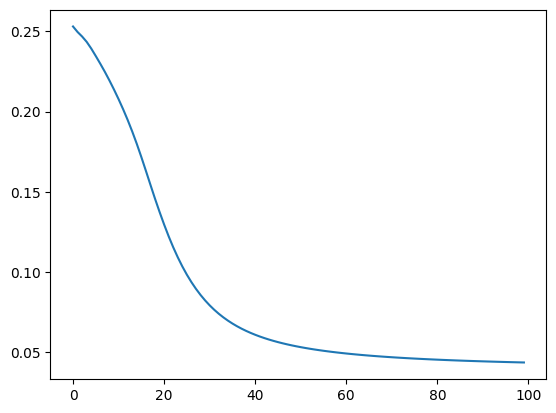

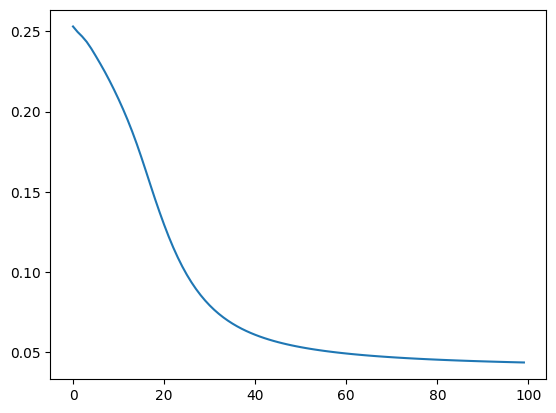

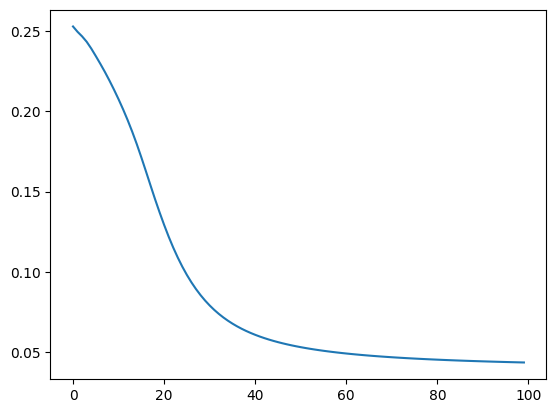

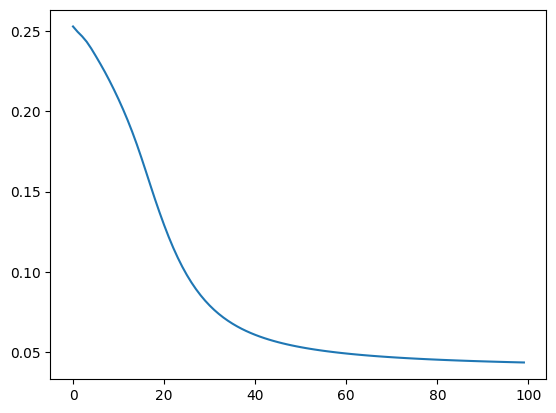

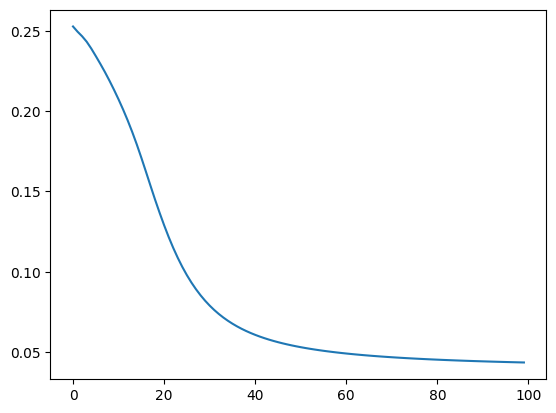

In [ ]:
# PRINT OPTIMIZATION PLOT FOR INDIVIDUAL PLOTS.
dbg1=True
if dbg1==True:
  for _ in range(noOfModels):
    plt.plot(model_loss_arr[_,:,0])
    plt.show()
    print()